# Exponential Weighted Moving Average for Network Rate Prediction

* imports and data acquisition 
* slice the data to keep only CERN-PROD to BNL-ATLAS (Production Input) transfers (filtered by site)
* Make predictions predictions:
 * for one transfer based in x previous transfers (x window size).
 * for a transfer y transfers in the future based on the best window size.
* Try with other links

In [1]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### RSE to Site

In [2]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

#### Get data

In [3]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-01'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if rse2site[r['src_rse']] != 'CERN-PROD':
        continue
    if rse2site[r['dst_rse']] != 'BNL-ATLAS':
        continue
    if not count%100000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_RATE'] = (data.SIZE/(data['ENDED'] - data['STARTED']))/(1024.*1024)
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']

['fts_2017-01-31', 'fts_2017-02-01', 'fts_2017-02-02', 'fts_2017-02-03', 'fts_2017-02-04', 'fts_2017-02-05', 'fts_2017-02-06', 'fts_2017-02-07', 'fts_2017-02-08']
0
100000
Reading took 563.7088384628296 seconds.


In [4]:
def holt_winters_second_order_ewma( x, span, beta ):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[0] = x[0]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s

#### slice the data to keep only CERN-PROD to BNL-ATLAS (Production Input) transfers (filtered by site)

In [60]:
cut = data.where(data.LINK == 'CERN-PROD__BNL-ATLAS__Production Input').dropna()
cut = cut.sort_values(by='STARTED')
cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
nr = np.append(np.zeros(1), cut.N_RATE.values)

#### Make predictions for all the transfers with window sizes from 1 to 100.

In [61]:
r2_scores = []
for winsize in range(1, 101, 1):
    cut['N_PRED_%d'%winsize] = holt_winters_second_order_ewma(nr, winsize, 0.07)[:-1]
    r2_scores.append(r2(cut.N_RATE, cut['N_PRED_%d'%winsize]))

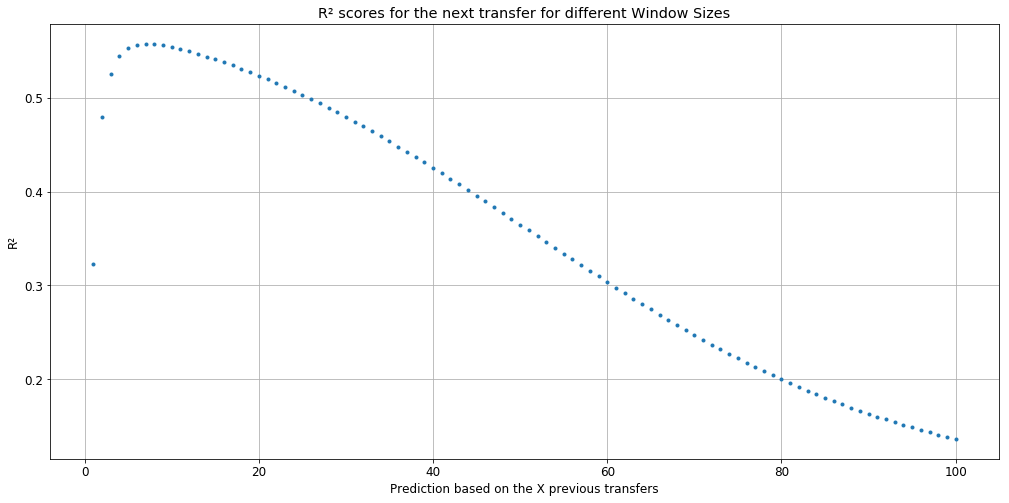

In [7]:
plt.plot(range(1,101),r2_scores, '.')
plt.title('R² scores for the next transfer for different Window Sizes')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Prediction based on the X previous transfers')
plt.ylabel('R²')

fig = plt.gcf()
fig.set_size_inches(17, 8)
#plt.legend()
plt.grid()
plt.show()

14004


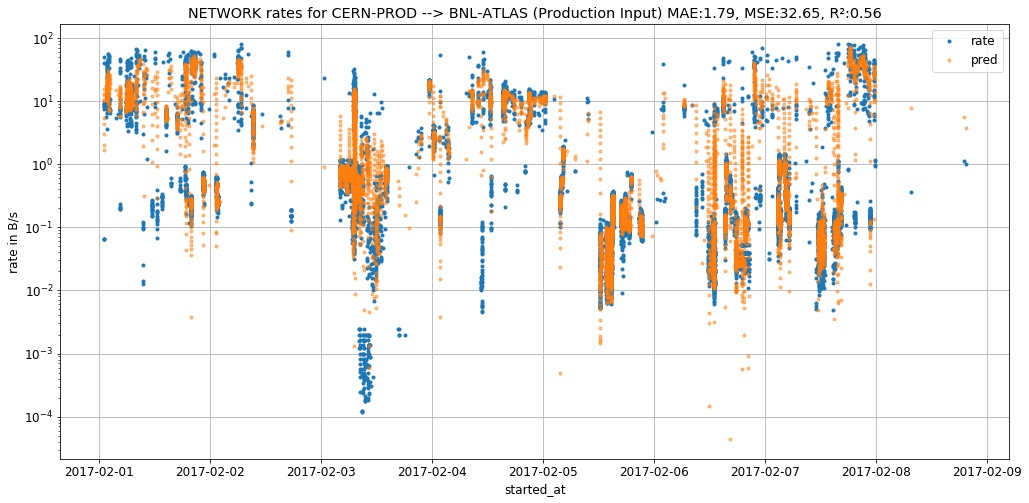

In [62]:
plt.plot(cut.index, cut.N_RATE,'.',label='rate')
plt.plot(cut.index, cut.N_PRED_8, '.', alpha=0.5, label='pred')
print(len(cut))
#s.expanding().mean()
n_mae = mae(cut.N_RATE, cut.N_PRED_8)
n_mse = mse(cut.N_RATE, cut.N_PRED_8)
n_r2 = r2(cut.N_RATE, cut.N_PRED_8)
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS (Production Input) MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(n_mae, n_mse,n_r2))
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('started_at')
plt.ylabel('rate in B/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

#### For the best window size, make predictions in the future (1 to 100 transfers ahead of the window)

In [9]:
r2_scores_ahead = []
pred = cut['N_PRED_8'].values
r2_scores_ahead.append(r2(cut.N_RATE, pred))
for t_ahead in range(1,101):
    pred = np.append(np.zeros(t_ahead), cut['N_PRED_8'].values)[:-t_ahead]
    r2_scores_ahead.append(r2(cut.N_RATE, pred))

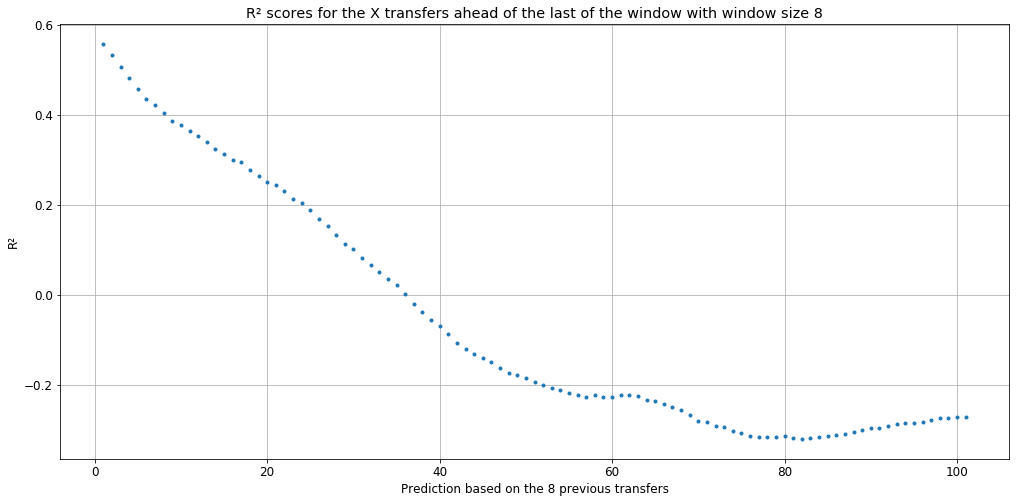

In [10]:
plt.plot(range(1,102),r2_scores_ahead, '.')
plt.title('R² scores for the X transfers ahead of the last of the window with window size 8')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Prediction based on the 8 previous transfers')
plt.ylabel('R²')

fig = plt.gcf()
fig.set_size_inches(17, 8)
#plt.legend()
plt.grid()
plt.show()

#### Make predictions ahead of the window for all the window sizes

In [11]:
r2_scores_ahead = [[]]*100
for winsize in range(1,101):
    r2_scores_ahead[winsize-1] = []
    pred = cut['N_PRED_%d'%winsize].values
    r2_scores_ahead[winsize-1].append(r2(cut.N_RATE, pred))
    for t_ahead in range(1,100):
        pred = np.append(np.zeros(t_ahead), cut['N_PRED_%d'%winsize].values)[:-t_ahead]
        r2_scores_ahead[winsize-1].append(r2(cut.N_RATE, pred))
r2s = np.array(r2_scores_ahead)
len(r2s[0].tolist())

100

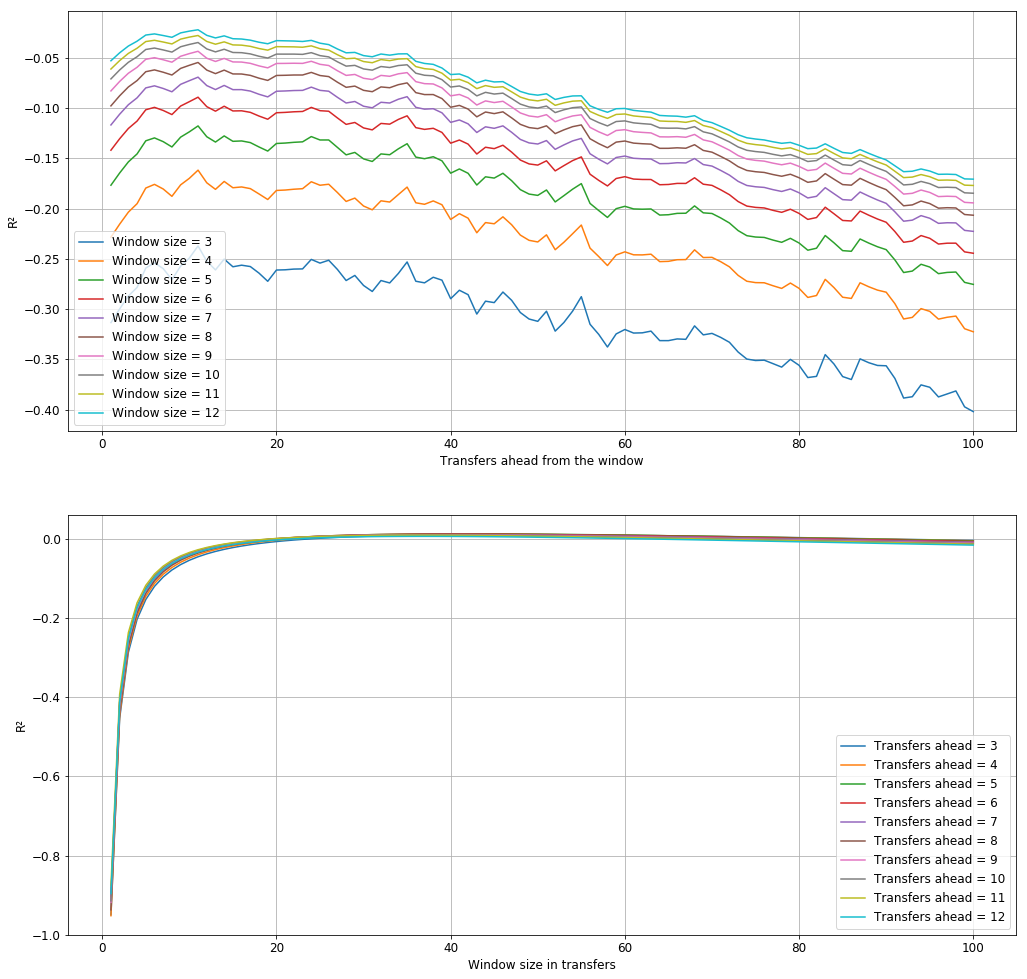

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1)
for ws in range(2,12,1):
    ax1.plot(range(1,101),r2s[ws], '-', label='Window size = %d'%(ws+1))
    ax2.plot(range(1,101),r2s.T[ws], '-', label='Transfers ahead = %d'%(ws+1))
    fig = plt.gcf()
#plt.title('R² vs Window size vs Transfers ahead of the window')
ax1.set_xlabel('Transfers ahead from the window')
ax2.set_xlabel('Window size in transfers')
ax1.set_ylabel('R²')
ax2.set_ylabel('R²')
fig.set_size_inches(17, 17)
ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()
plt.show()

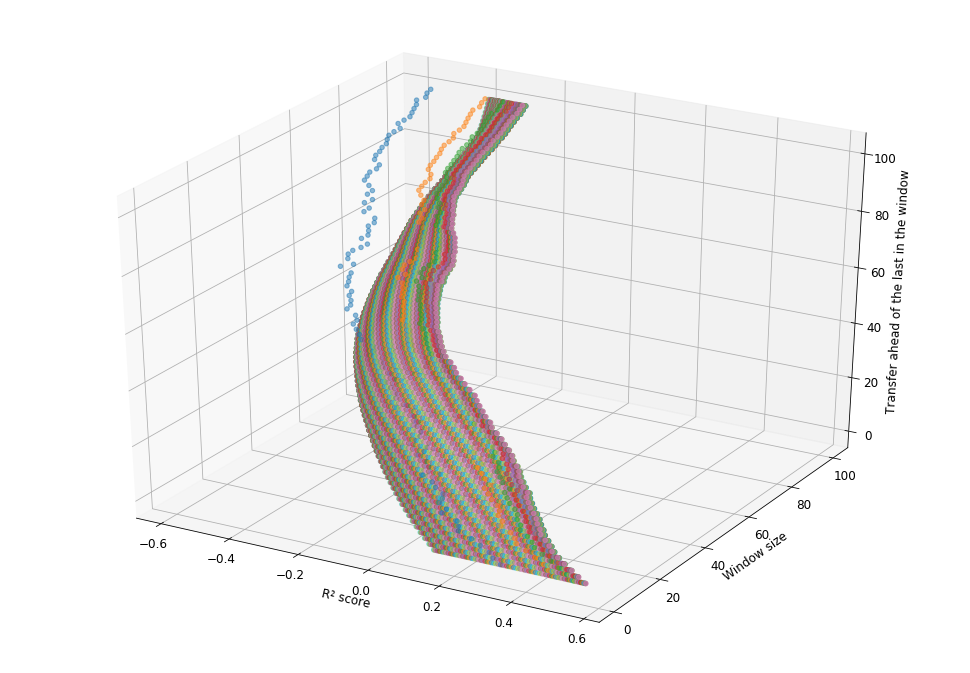

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fplot = plt.figure().gca(projection='3d')
for i in range(100):
    fplot.scatter3D(r2s[i],range(1,101), range(1,101),alpha=0.5)
#fplot.scatter(cut.SIZE_MB,cut.LINK_RATE,cut.N_PRED,'o',alpha=0.5)
fplot.set_ylabel('Window size')
fplot.set_xlabel('R² score')
fplot.set_zlabel('Transfer ahead of the last in the window')
fig = plt.gcf()
fig.set_size_inches(17, 12)
#plt.legend()
plt.grid()
plt.show()

## Trying Another Link (CERN,BNL, Prod output)

30830


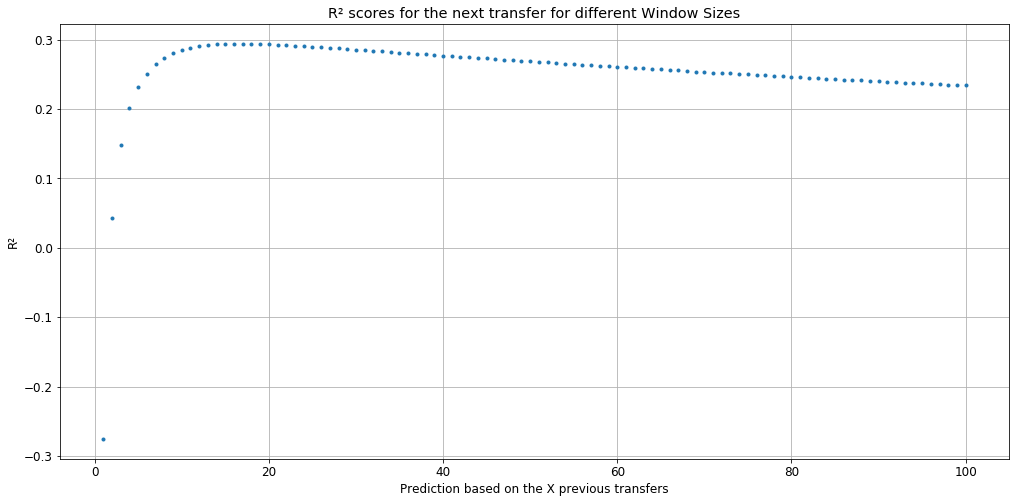

In [54]:
cut = data.where(data.LINK == 'CERN-PROD__BNL-ATLAS__Production Output').dropna()
cut = cut.sort_values(by='STARTED')
cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
nr = np.append(np.zeros(1), cut.N_RATE.values)
print(len(cut))

r2_scores = []
for winsize in range(1, 101, 1):
    cut['N_PRED_%d'%winsize] = holt_winters_second_order_ewma(nr, winsize, 0.01)[:-1]
    r2_scores.append(r2(cut.N_RATE, cut['N_PRED_%d'%winsize]))
plt.plot(range(1,101),r2_scores, '.')
plt.title('R² scores for the next transfer for different Window Sizes')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Prediction based on the X previous transfers')
plt.ylabel('R²')

fig = plt.gcf()
fig.set_size_inches(17, 8)
#plt.legend()
plt.grid()
plt.show()

#### Predictions using the best window size

30830


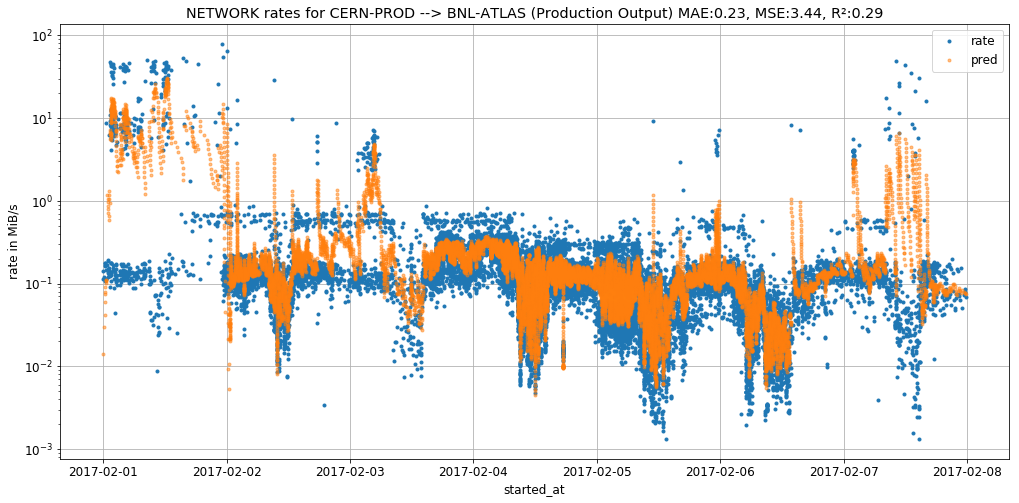

In [58]:
plt.plot(cut.index, cut.N_RATE,'.', label='rate')
plt.plot(cut.index, cut.N_PRED_15, '.', alpha=0.5, label='pred')
print(len(cut))
#s.expanding().mean()
n_mae = mae(cut.N_RATE, cut.N_PRED_15)
n_mse = mse(cut.N_RATE, cut.N_PRED_15)
n_r2 = r2(cut.N_RATE, cut.N_PRED_15)
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS (Production Output) MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(n_mae, n_mse,n_r2))
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('started_at')
plt.ylabel('rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [34]:
r2_scores_ahead = [[]]*100
for winsize in range(1,101):
    r2_scores_ahead[winsize-1] = []
    pred = cut['N_PRED_%d'%winsize].values
    r2_scores_ahead[winsize-1].append(r2(cut.N_RATE, pred))
    for t_ahead in range(1,100):
        pred = np.append(np.zeros(t_ahead), cut['N_PRED_%d'%winsize].values)[:-t_ahead]
        r2_scores_ahead[winsize-1].append(r2(cut.N_RATE, pred))
r2s = np.array(r2_scores_ahead)
len(r2s[0].tolist())

100

### Several window sizes and predictions ahead

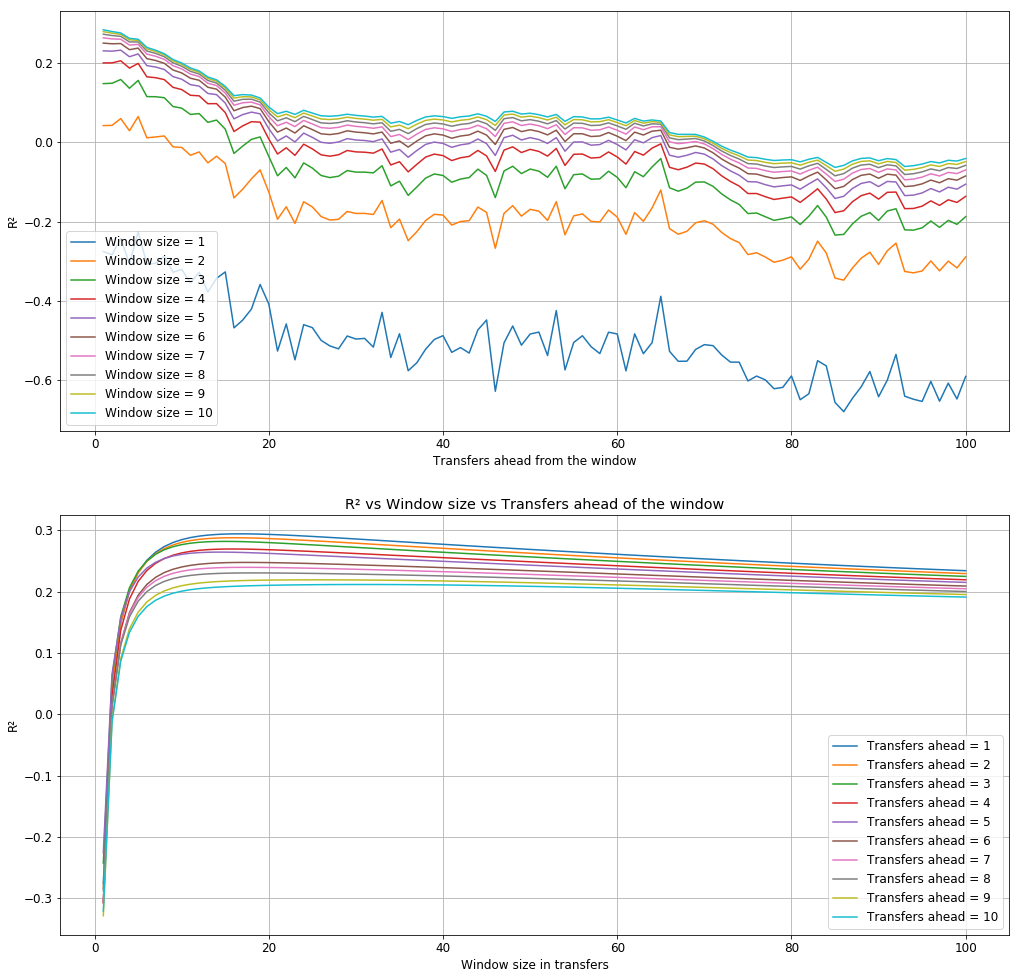

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1)
for ws in range(0,10,1):
    ax1.plot(range(1,101),r2s[ws], '-', label='Window size = %d'%(ws+1))
    ax2.plot(range(1,101),r2s.T[ws], '-', label='Transfers ahead = %d'%(ws+1))
    fig = plt.gcf()
plt.title('R² vs Window size vs Transfers ahead of the window')
ax1.set_xlabel('Transfers ahead from the window')
ax2.set_xlabel('Window size in transfers')
ax1.set_ylabel('R²')
ax2.set_ylabel('R²')
fig.set_size_inches(17, 17)
ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()
plt.show()

## Trying yet another link (CERN,BNL,Express)

12332


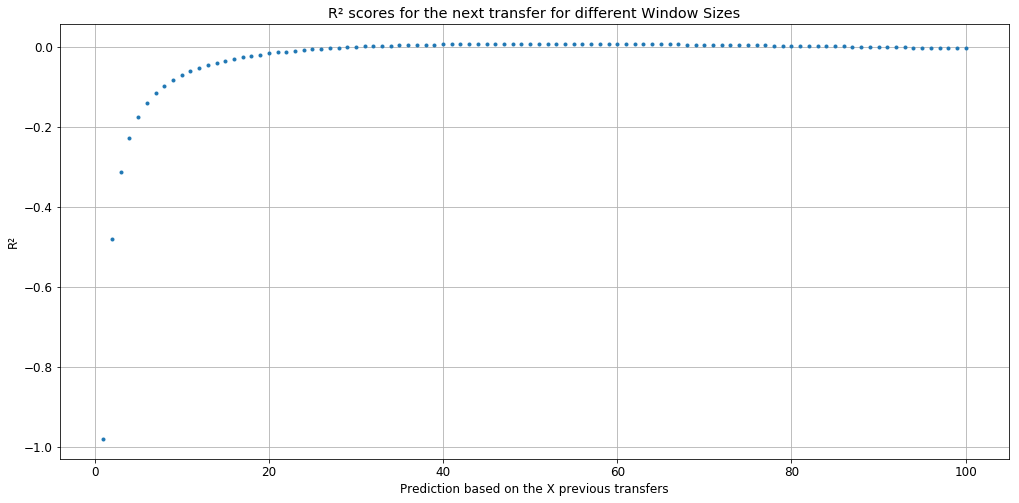

In [44]:
cut = data.where(data.LINK == 'CERN-PROD__BNL-ATLAS__Express').dropna()
cut = cut.sort_values(by='STARTED')
nr = np.append(np.zeros(1), cut.N_RATE.values)
print(len(cut))

r2_scores = []
for winsize in range(1, 101, 1):
    cut['N_PRED_%d'%winsize] = holt_winters_second_order_ewma(nr, winsize, 0.01)[:-1]
    r2_scores.append(r2(cut.N_RATE, cut['N_PRED_%d'%winsize]))
plt.plot(range(1,101),r2_scores, '.')
plt.title('R² scores for the next transfer for different Window Sizes')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Prediction based on the X previous transfers')
plt.ylabel('R²')

fig = plt.gcf()
fig.set_size_inches(17, 8)
#plt.legend()
plt.grid()
plt.show()

#### predictions for the best window size

12332


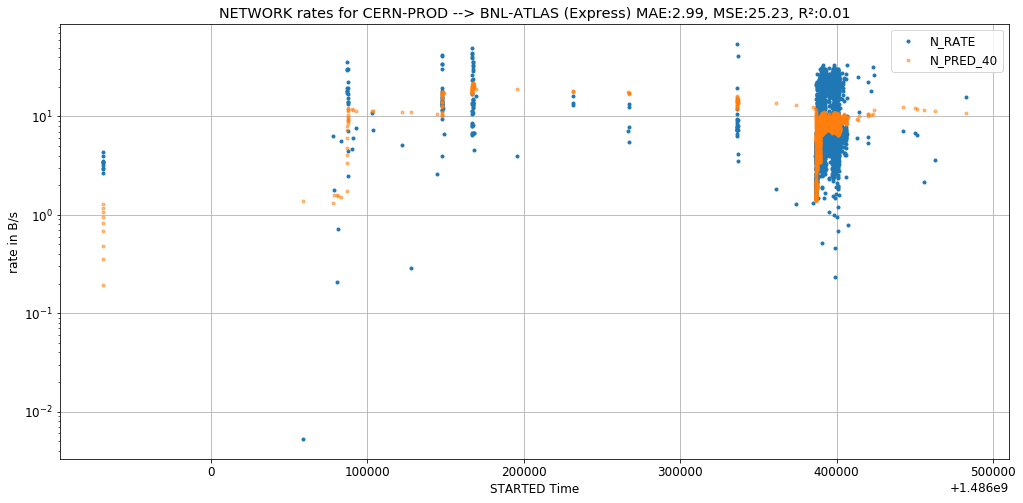

In [48]:
plt.plot(cut.STARTED, cut.N_RATE,'.')
plt.plot(cut.STARTED, cut.N_PRED_40, '.', alpha=0.5)
print(len(cut))
#s.expanding().mean()
n_mae = mae(cut.N_RATE, cut.N_PRED_40)
n_mse = mse(cut.N_RATE, cut.N_PRED_40)
n_r2 = r2(cut.N_RATE, cut.N_PRED_40)
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS (Express) MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(n_mae, n_mse,n_r2))
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('STARTED Time')
plt.ylabel('rate in B/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [46]:
r2_scores_ahead = [[]]*100
for winsize in range(1,101):
    r2_scores_ahead[winsize-1] = []
    pred = cut['N_PRED_%d'%winsize].values
    r2_scores_ahead[winsize-1].append(r2(cut.N_RATE, pred))
    for t_ahead in range(1,100):
        pred = np.append(np.zeros(t_ahead), cut['N_PRED_%d'%winsize].values)[:-t_ahead]
        r2_scores_ahead[winsize-1].append(r2(cut.N_RATE, pred))
r2s = np.array(r2_scores_ahead)
len(r2s[0].tolist())

100

### Several window sizes and transfers ahead

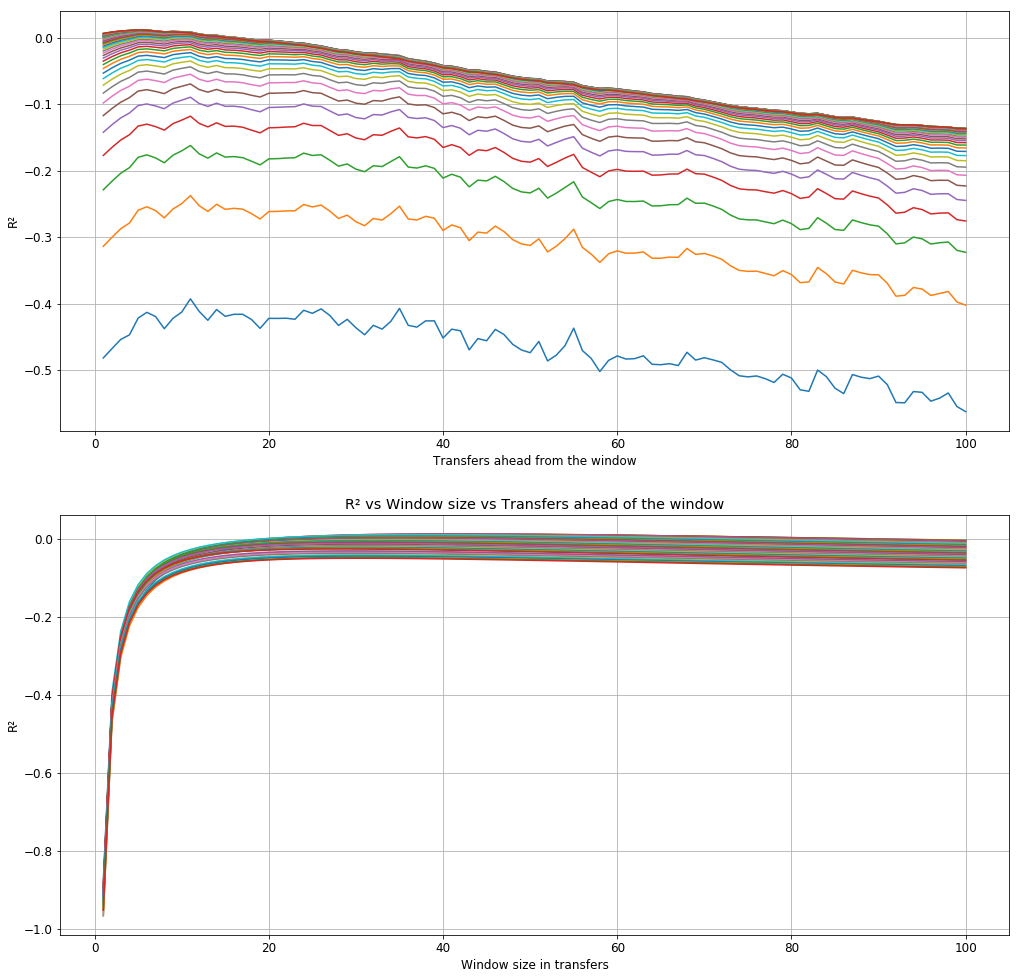

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1)
for ws in range(1,45,1):
    ax1.plot(range(1,101),r2s[ws], '-', label='Window size = %d'%(ws+1))
    ax2.plot(range(1,101),r2s.T[ws], '-', label='Transfers ahead = %d'%(ws+1))
    fig = plt.gcf()
plt.title('R² vs Window size vs Transfers ahead of the window')
ax1.set_xlabel('Transfers ahead from the window')
ax2.set_xlabel('Window size in transfers')
ax1.set_ylabel('R²')
ax2.set_ylabel('R²')
fig.set_size_inches(17, 17)
#ax1.legend()
ax1.grid()
#ax2.legend()
ax2.grid()
plt.show()